# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

### Читаем csv файлы, выводим данные на экран, смотрим общую информацию

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Посмотрим количество пропусков в процентном соотношении.

In [5]:
def search_for_passes(data):
    print("|{: <20}|".format("Столбец"),"{: <20}|".format("количество пропусков"),"{: <25}|".format("процент от общего числа"))
    print('-----------------------------------------------------------------------')
    for i in data.columns:
        if data[i].isna().sum() != 0:
            print("|{: <20}|".format(i),"{: ^20}|".format(data[i].isna().sum()),"{: ^25.1%}|".format(data[i].isna().sum()/data.shape[0]))

In [6]:
search_for_passes(data)

|Столбец             | количество пропусков| процент от общего числа  |
-----------------------------------------------------------------------
|VehicleType         |        37490        |           10.6%          |
|Gearbox             |        19833        |           5.6%           |
|Model               |        19705        |           5.6%           |
|FuelType            |        32895        |           9.3%           |
|NotRepaired         |        71154        |           20.1%          |


В данных мощности двигателя есть нулевые значения и  неестественно большие значения, изучим данные подробнее.

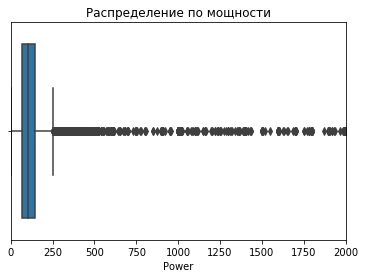

In [7]:
sns.boxplot(x=data['Power'])
plt.xlim([0,2000])
plt.title('Распределение по мощности')
plt.show()

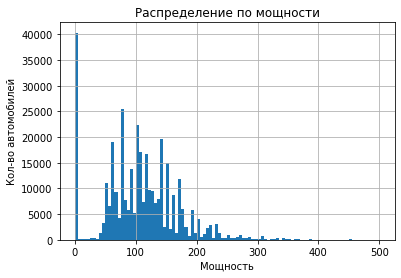

In [8]:
data.hist('Power',bins=100, range = (0,500))
plt.xlabel('Мощность')
plt.ylabel('Кол-во автомобилей')
plt.title('Распределение по мощности')
plt.show()

Нулевые значения и зачения больше 1000 л.с будем считать выбросами и заменим средними значениями по моделям.

In [9]:
data_power = data.groupby(['Brand', 'Model'])['Power'].median().reset_index()
data_power = data_power.rename(columns={"Power": "Power_mean"})
data_power

,Brand,Model,Power_mean
0,alfa_romeo,145,103.0
1,alfa_romeo,147,120.0
2,alfa_romeo,156,150.0
3,alfa_romeo,159,165.0
4,alfa_romeo,other,150.0
...,...,...,...
292,volvo,v40,116.0
293,volvo,v50,136.0
294,volvo,v60,163.0
295,volvo,v70,163.0


In [10]:
data = data.merge(data_power, how='outer',on = ['Model','Brand'])
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Power_mean
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,95.0
1,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,95.0
2,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06,95.0
3,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43,95.0
4,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08 00:00:00,0,19386,2016-03-08 09:44:50,95.0


In [11]:
data['Power'] = data['Power'].where(data['Power'] != 0, data['Power_mean'])
data['Power'] = data['Power'].where(data['Power'] < 1000, data['Power_mean'])
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Power_mean
0,2016-03-24 11:52:17,480,NaN,1993,manual,95.0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,95.0
1,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,95.0
2,2016-03-17 10:53:50,999,small,1998,manual,101.0,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06,95.0
3,2016-03-15 20:59:01,245,sedan,1994,NaN,95.0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43,95.0
4,2016-03-08 07:54:46,350,NaN,2016,manual,75.0,golf,150000,4,petrol,volkswagen,no,2016-03-08 00:00:00,0,19386,2016-03-08 09:44:50,95.0


Оставшиеся 0 заменим на пропуски и удалим.

In [12]:
data['Power'] = data['Power'].replace(0, np.nan)
data.dropna(inplace=True)

Заменим пропуски в типах автомобильного кузова, в соотвествии с моделью автомобиля.

In [13]:
models_vehType = data.groupby("Model")['VehicleType'].agg(lambda x:x.value_counts().index[0]).to_dict()

def VehicleType_change(row):

    model = row["Model"]
    veh_Type = row["VehicleType"]
    
    if model == "None" and veh_Type == "None":
        return "None"
    elif model == "None" and veh_Type != "None":
        return veh_Type
    
    return models_vehType[model]


data["Model"] = data["Model"].fillna("None")
data["VehicleType"] = data["VehicleType"].fillna("None")

data["VehicleType"] = data[["VehicleType", "Model"]].apply(VehicleType_change, axis=1)

Если NotRepaired пропущено, считаем, что продавец имеет ввиду отсутствие ремонта

In [14]:
data["NotRepaired"].fillna("no", inplace=True)

Остальные пропущенные значения удалим.

In [15]:
data.dropna(inplace=True)

Проверим наличие дубликатов, и если они есть удалим их.

In [16]:
data.duplicated().sum()

4

In [17]:
data=data.drop_duplicates().reset_index(drop=True)

Изучим данные с ценой автомобиля.

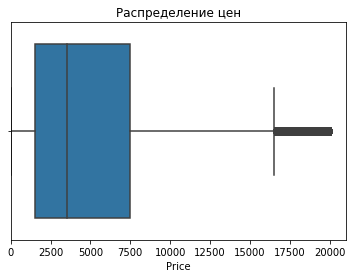

In [18]:
sns.boxplot(x=data['Price'])
plt.xlim([0,21000])
plt.title('Распределение цен')
plt.show()

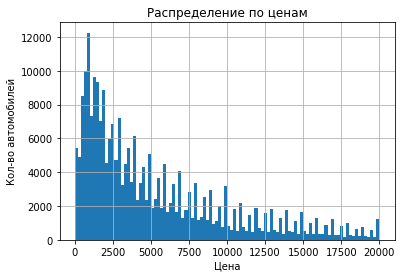

In [19]:
data.hist('Price',bins=100, range = (0,20000))
plt.xlabel('Цена')
plt.ylabel('Кол-во автомобилей')
plt.title('Распределение по ценам')
plt.show()

В ценах на автомобиле присутствуют нулевые значения, удалим их, предварительно, замнив их на пропуски.

In [20]:
data['Price'] = data['Price'].replace(0, np.nan)
data.dropna(inplace=True)

Избавимся от аномалий в значениях года регистрации автомобиля. 

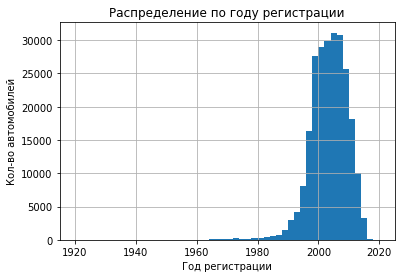

In [21]:
data.hist('RegistrationYear',bins=50, range = (1920,2020))
plt.xlabel('Год регистрации')
plt.ylabel('Кол-во автомобилей')
plt.title('Распределение по году регистрации')
plt.show()

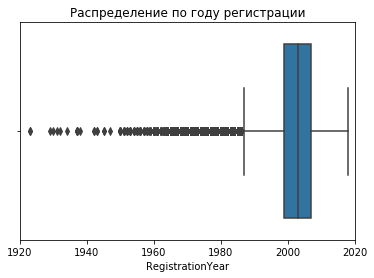

In [22]:
sns.boxplot(x=data['RegistrationYear'])
plt.xlim([1920,2020])
plt.title('Распределение по году регистрации')
plt.show()

In [23]:
P = [1900, 2021]
data = data[(data['RegistrationYear'] >= P[0]) & (data['RegistrationYear'] <= P[1])]

Дата скачивания анкеты из базы и дата создания анкеты практически не отличаются, поэтому сохранять оба столбца не имеет смысла - удалим DateCrawled. Так же удалим данные не влияющие на формирование цены, это дата последней активности пользователя.

In [24]:
data.drop(['DateCrawled','LastSeen','Power_mean'], axis=1, inplace=True)

Добавим столбец день недели, месяц и год создания объвления

In [25]:
data["DateCreated"] = pd.to_datetime(data["DateCreated"]).dt.round("D")
data["weekday"] = data["DateCreated"].dt.weekday
data["month"] = data["DateCreated"].dt.month
data["year"] = data["DateCreated"].dt.year

data.drop('DateCreated', axis=1, inplace=True)

Проверим данные на мультиколлинеарность.

In [26]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,weekday,month,year
Price,1.000000,0.556227,0.501518,-0.401482,0.040991,NaN,0.062393,0.018368,0.016574,-0.002535
RegistrationYear,0.556227,1.000000,0.148986,-0.357303,0.033171,NaN,0.033571,0.011504,0.002664,-0.003220
Power,0.501518,0.148986,1.000000,0.114655,0.030435,NaN,0.051981,-0.004459,0.003970,0.000216
Kilometer,-0.401482,-0.357303,0.114655,1.000000,-0.006332,NaN,-0.010662,-0.015852,-0.002410,0.005039
RegistrationMonth,0.040991,0.033171,0.030435,-0.006332,1.000000,NaN,0.002006,0.004014,-0.002449,0.003070
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.062393,0.033571,0.051981,-0.010662,0.002006,NaN,1.000000,0.011654,0.011199,0.002582
weekday,0.018368,0.011504,-0.004459,-0.015852,0.004014,NaN,0.011654,1.000000,0.123751,-0.000874
month,0.016574,0.002664,0.003970,-0.002410,-0.002449,NaN,0.011199,0.123751,1.000000,-0.178337
year,-0.002535,-0.003220,0.000216,0.005039,0.003070,NaN,0.002582,-0.000874,-0.178337,1.000000


Сильных парных линейных связей (т.е. корреляция, >0,7) не наблюдаем.

In [27]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode,weekday,month,year
0,1500.0,sedan,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,0,91074,3,3,2016
1,1000.0,sedan,1998,manual,101.0,golf,150000,10,petrol,volkswagen,no,0,39624,3,3,2016
2,6600.0,sedan,2006,manual,105.0,golf,150000,10,gasoline,volkswagen,no,0,41812,3,3,2016
3,6300.0,sedan,2002,manual,265.0,golf,150000,3,petrol,volkswagen,no,0,56759,6,3,2016
4,1000.0,sedan,1990,manual,54.0,golf,150000,2,petrol,volkswagen,no,0,47447,4,3,2016


### Вывод

В процессе предобработки данных избавились от пропусков в данных, избавились от выбросов, удалили данные не влияющие на дальнейшее исследование,так же удалили дубликаты.

## Обучение моделей

###  LightGBM

Для обучения преобразум категориальные признаки в численные.

In [28]:
categorical  = ['VehicleType', 'Gearbox', 'Model', 'Brand', 'NotRepaired','FuelType']
label_encoder = LabelEncoder()

for col in categorical:
    data[col] = label_encoder.fit_transform(data[col])

Выделим 25% данных для тестовой выборки, остальные — для обучающей.

In [29]:
features_cat = data.drop(['Price'], axis=1) 
target_cat =data['Price'] 

features_train_cat, features_test_cat, target_train_cat, target_test_cat = train_test_split(features_cat, target_cat, test_size=0.25, random_state=1234)

In [31]:
%%time
params_lgbm = {'n_estimators': range (10, 200, 50),
              'max_depth': range (3, 6, 1)}
lgbm = LGBMRegressor()
grid_lgbm = GridSearchCV(lgbm,params_lgbm, cv=5, n_jobs=-1)
grid_lgbm.fit(features_train_cat, target_train_cat)

CPU times: user 31min, sys: 11.7 s, total: 31min 11s
Wall time: 31min 22s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': range(3, 6),
                         'n_estimators': range(10, 200, 50)},
             pre_dispatch='2*n_jobs', refit=True, return_tr

In [33]:
%%time
predicted_test_lgbm = grid_lgbm.predict(features_test_cat)
mse = mean_squared_error(target_test_cat, predicted_test_lgbm)
print("RMSE =", mse ** 0.5)

RMSE = 1715.464408765193
CPU times: user 1.25 s, sys: 10.2 ms, total: 1.26 s
Wall time: 1.28 s


### CatBoost

In [34]:
%%time
params_cat = {'n_estimators': range (50, 200, 50),
             'max_depth': range (5, 15, 5)} 
model_CatBoost = CatBoostRegressor(cat_features=categorical, verbose=100)
grid_CB = GridSearchCV(model_CatBoost, params_cat, cv=5)
grid_CB.fit(features_train_cat, target_train_cat)

0:	learn: 4609.9662821	total: 208ms	remaining: 10.2s
49:	learn: 2492.3543891	total: 9.97s	remaining: 0us
0:	learn: 4619.3071724	total: 128ms	remaining: 6.27s
49:	learn: 2497.6555495	total: 9.9s	remaining: 0us
0:	learn: 4603.0040217	total: 127ms	remaining: 6.23s
49:	learn: 2502.6880125	total: 9.84s	remaining: 0us
0:	learn: 4608.7735229	total: 137ms	remaining: 6.73s
49:	learn: 2493.5312241	total: 9.91s	remaining: 0us
0:	learn: 4616.0440779	total: 186ms	remaining: 9.13s
49:	learn: 2503.1061839	total: 10s	remaining: 0us
0:	learn: 4609.9662821	total: 186ms	remaining: 18.4s
99:	learn: 2062.0942480	total: 20.2s	remaining: 0us
0:	learn: 4619.3071724	total: 140ms	remaining: 13.9s
99:	learn: 2068.3776286	total: 19.9s	remaining: 0us
0:	learn: 4603.0040217	total: 177ms	remaining: 17.5s
99:	learn: 2073.9175711	total: 19.7s	remaining: 0us
0:	learn: 4608.7735229	total: 171ms	remaining: 16.9s
99:	learn: 2067.1175020	total: 20.1s	remaining: 0us
0:	learn: 4616.0440779	total: 199ms	remaining: 19.7s
99:	l

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7fd19e71b450>,
             iid='warn', n_jobs=None,
             param_grid={'max_depth': range(5, 15, 5),
                         'n_estimators': range(50, 200, 50)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [35]:
%%time
predicted_test_CatBoost = grid_CB.predict(features_test_cat)
mse = mean_squared_error(target_test_cat, predicted_test_CatBoost)
print("RMSE =", mse ** 0.5)

RMSE = 1783.9348729943456
CPU times: user 291 ms, sys: 41.1 ms, total: 332 ms
Wall time: 327 ms


### RandomForest

In [36]:
%%time
params_cat = {'max_depth': range(5, 15, 3),
             'n_estimators': range (5, 25, 5)} 
model_RF = RandomForestRegressor()
grid_RF = GridSearchCV(model_RF, params_cat, cv=5)
grid_RF.fit(features_train_cat, target_train_cat)

CPU times: user 7min 16s, sys: 0 ns, total: 7min 16s
Wall time: 7min 22s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': range(5, 15, 3),
 

In [37]:
%%time
predicted_test_RF = grid_RF.predict(features_test_cat)
mse = mean_squared_error(target_test_cat, predicted_test_RF)
print("RMSE =", mse ** 0.5)

RMSE = 1699.1165497030513
CPU times: user 257 ms, sys: 0 ns, total: 257 ms
Wall time: 268 ms


### LinearRegression

Для линейной регрессии преобразум категориальные признаки в численные техникой прямого кодирования, или отображения (One-Hot Encoding, OHE).

In [38]:
data_ohe = pd.get_dummies(data, columns=categorical, drop_first=True)
features_ohe = data_ohe.drop(['Price'], axis=1) 
target_ohe = data_ohe['Price']
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.25, random_state=1234)
data_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,weekday,month,year,...,Brand_36,Brand_37,Brand_38,NotRepaired_1,FuelType_1,FuelType_2,FuelType_3,FuelType_4,FuelType_5,FuelType_6
0,1500.0,2001,75.0,150000,6,0,91074,3,3,2016,...,0,1,0,0,0,0,0,0,0,1
1,1000.0,1998,101.0,150000,10,0,39624,3,3,2016,...,0,1,0,0,0,0,0,0,0,1
2,6600.0,2006,105.0,150000,10,0,41812,3,3,2016,...,0,1,0,0,0,1,0,0,0,0
3,6300.0,2002,265.0,150000,3,0,56759,6,3,2016,...,0,1,0,0,0,0,0,0,0,1
4,1000.0,1990,54.0,150000,2,0,47447,4,3,2016,...,0,1,0,0,0,0,0,0,0,1


Выделим 25% данных для тестовой выборки, остальные — для обучающей.

In [39]:
features = data_ohe.drop(['Price'], axis=1) 
target = data_ohe['Price'] 

In [40]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Для масштабирования зафиксируем численные признаки.

In [41]:
numeric = ['Kilometer', 'PostalCode','Power','RegistrationMonth']

Создаём объект структуры StandardScaler() и настраиваем его на обучающих данных и масштабируем численные признаки

In [42]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None
features_train.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,weekday,month,year,VehicleType_1,...,Brand_36,Brand_37,Brand_38,NotRepaired_1,FuelType_1,FuelType_2,FuelType_3,FuelType_4,FuelType_5,FuelType_6
130206,1998,-0.154968,0.613721,0.523085,0,-1.492207,1,3,2016,0,...,0,0,0,1,0,1,0,0,0,0
237981,1998,0.403985,0.613721,1.675413,0,-0.094026,0,4,2016,0,...,0,0,1,0,0,0,0,0,0,1
37363,2004,-0.248127,-1.274554,-1.493487,0,0.174984,2,3,2016,0,...,0,0,0,0,0,0,0,0,0,1
169413,2009,0.329458,0.613721,-0.629242,0,1.649079,6,3,2016,0,...,0,0,0,0,0,1,0,0,0,0
206340,2000,-0.117704,0.613721,-0.053078,0,-0.224463,6,3,2016,0,...,0,0,0,0,0,1,0,0,0,0


In [43]:
%%time

lr = LinearRegression(normalize=True)
lr.fit(features_train, target_train)

CPU times: user 17.5 s, sys: 12.9 s, total: 30.3 s
Wall time: 30.4 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [44]:
%%time
predicted_train_lr = lr.predict(features_test)
mse = mean_squared_error(target_test, predicted_train_lr)
print("RMSE =", mse ** 0.5)

RMSE = 2585.585663621043
CPU times: user 129 ms, sys: 95.2 ms, total: 224 ms
Wall time: 193 ms


## Анализ моделей

In [47]:
time = [["31min 11s", "1.26 s", 1715],
        ["15min 39s", "332 ms", 1783],
        ["7min 16s", "257 ms", 1699],
        ["30.3 s", "224 ms", 2585]]
model = ["LGBM", "Catboost", "RandomForest", "LinearRegression"]

In [48]:
pd.DataFrame(data=time, index=model, columns=["fit_time", "predict_time", "RMSE"])

,fit_time,predict_time,RMSE
LGBM,31min 11s,1.26 s,1715
Catboost,15min 39s,332 ms,1783
RandomForest,7min 16s,257 ms,1699
LinearRegression,30.3 s,224 ms,2585


Найлучший показатель RMSE дала модель RandomForest, это тот редкий случай когда более простая модель работает лучше. Модели бустинга Catboost и LightGBM дали примерно одинаковые показатели RMSE, но модель LightGBM обучалась вдвое дольше. Худший показатель RMSE показала LinearRegression, при самом быстром обучении.